data from https://www.kaggle.com/kaushiksuresh147/customer-segmentation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 数据预处理与可视化

## 1.1 数据初步预览

In [2]:
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')

# 由于我们这里要练习聚类算法(无监督学习),所以其实不需要验证集
train = pd.concat([train, test], axis = 0, ignore_index=True)

In [3]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 919.2+ KB


可以看到部分列有空值.由于有空值的列较多,所以写代码查看哪些列包含有空值(一个个肉眼找太麻烦)

In [5]:
has_null = set()
for feature in train:
    if train[feature].count() != len(train):
        has_null.add(feature)
print(has_null)

{'Family_Size', 'Var_1', 'Work_Experience', 'Ever_Married', 'Graduated', 'Profession'}


In [6]:
train.describe(include = 'all')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,10695.000000,10695,10505,10695.000000,10593,10533,9597.000000,10695,10247.000000,10587,10695
unique,NaN,2,2,NaN,2,9,NaN,3,NaN,7,4
top,NaN,Male,Yes,NaN,Yes,Artist,NaN,Low,NaN,Cat_6,D
freq,NaN,5841,6163,NaN,6570,3318,NaN,6494,NaN,6910,3027
mean,463468.088640,NaN,NaN,43.511828,NaN,NaN,2.619777,NaN,2.844052,NaN,NaN
std,2600.966411,NaN,NaN,16.774158,NaN,NaN,3.390790,NaN,1.536427,NaN,NaN
min,458982.000000,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,461220.500000,NaN,NaN,30.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,463451.000000,NaN,NaN,41.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN
75%,465733.500000,NaN,NaN,53.000000,NaN,NaN,4.000000,NaN,4.000000,NaN,NaN


In [7]:
test_idx = test['ID']
train.drop('ID', axis = 1, inplace = True)
test.drop('ID', axis = 1, inplace = True)

In [8]:
num_vals = []
cat_vals = []
for feature in train:
    if train[feature].dtype != 'object':
        num_vals.append(feature)
    else:
        cat_vals.append(feature)
cat_vals.remove('Segmentation')
print("数值型变量为" + str(num_vals))
print("离散型变量为" + str(cat_vals))

数值型变量为['Age', 'Work_Experience', 'Family_Size']
离散型变量为['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']


看一下目标客户应该分为哪几类

In [9]:
train['Segmentation'].value_counts()

D    3027
A    2818
C    2442
B    2408
Name: Segmentation, dtype: int64

## 1.2 数据可视化

先进行可视化,再进行空值的填充

首先我们要确定'Work_Experience', 'Family_Size'这两个看起来项数比较少的变量的唯一值个数以判断是否将其和Age放在一起进行可视化

唯一值个数在describe对应项下的unique中可以查看, 但也可以查看其value_counts()长度

In [10]:
for val in ['Work_Experience', 'Family_Size']:
    print("%s中唯一值个数为%d" % (val, len(train[val].value_counts())))

Work_Experience中唯一值个数为15
Family_Size中唯一值个数为9


值的个数不是非常多, 可以使用seaborn中类型为"dodge"堆叠模式的直方图进行查看

In [11]:
def batch_num_plotting(row, col, idx, x, hue, data):
    plt.subplot(row, col, idx)
    sns.histplot(data=data, x=x, hue=hue, multiple="dodge")

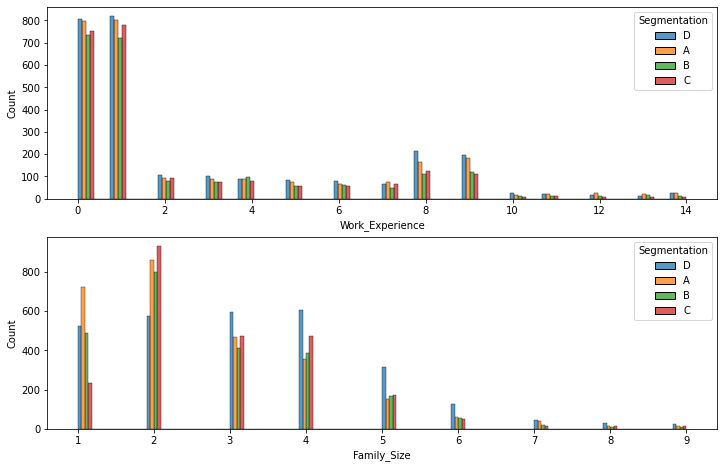

In [12]:
plt.figure(figsize=[12,12])
to_plot = ['Work_Experience', 'Family_Size']
for i in range(len(to_plot)):
    batch_num_plotting(3, 1, i + 1, x = to_plot[i], hue = 'Segmentation', data = train)

由于Age的唯一值较多,所以我们使用折线图观察

In [13]:
age_type = {}
for seg in train.Segmentation.value_counts().index:
    age_type[seg] = pd.DataFrame(train[train['Segmentation'] == seg], columns=['Age']).Age.value_counts()

In [14]:
# matplotlib 基础颜色,来源 https://matplotlib.org/stable/api/colors_api.html#module-matplotlib.colors
base_colors =  ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def plot_age(seg_name, color):
    x = sorted(age_type[seg_name].keys().tolist())
    y = sorted(age_type[seg_name].values.tolist())
    # label用于图例命名
    plt.plot(x, y, color = color, label = seg_name)

Text(0.5, 1.0, 'Age-Segmentation line plot')

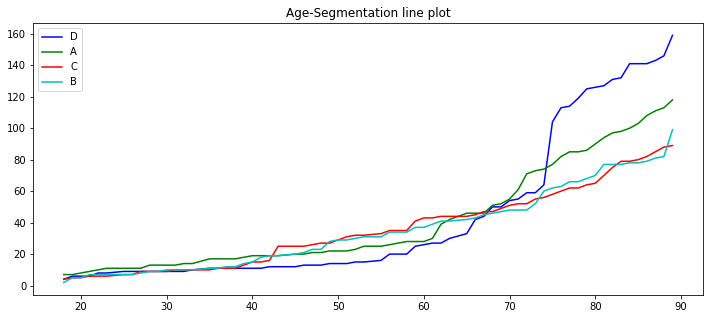

In [15]:
plt.figure(figsize=[12,5])
total_len = len(age_type)
curidx = 0
for tp in age_type.keys():
    plot_age(tp, color = base_colors[curidx])
    curidx += 1
# 显示图例
plt.legend(loc='best')
plt.title("Age-Segmentation line plot")

对于离散型变量,直接使用countplot观察.为了方便定义一个函数节省代码量

In [16]:
def plot_cat(row, col, idx, x, hue, data):
    plt.subplot(row, col, idx)
    sns.countplot(x=x, hue=hue, data=data)
    # 默认绘图效果不是很好所以给图例加了个best参数.由于seaborn是matplotlib的扩展库,所以可以使用matplotlib方法直接控制seaborn的绘图
    plt.legend(loc= 'best')

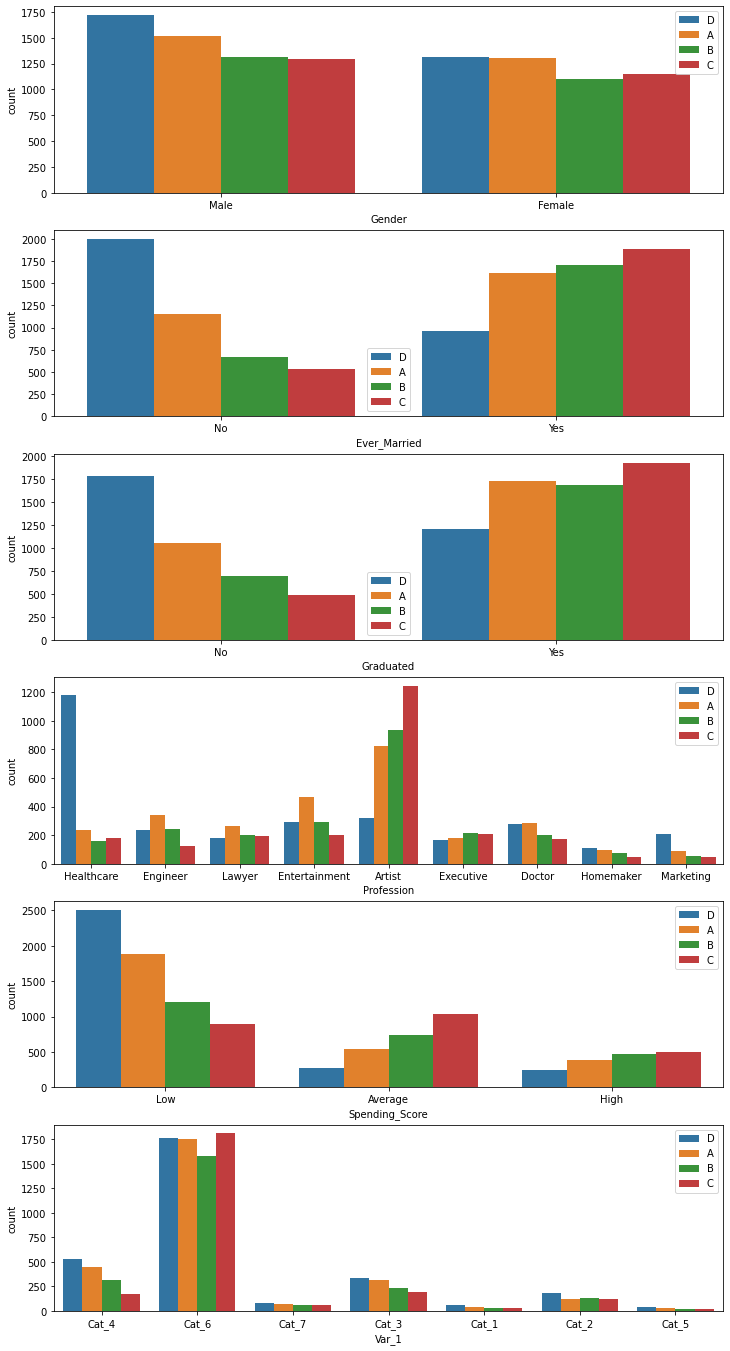

In [17]:
l = len(cat_vals)
plt.figure(figsize=[12,4 * l])
for i in range(len(cat_vals)):
    plot_cat(l, 1, i + 1, cat_vals[i], 'Segmentation', train)

## 1.3 空值填充

我们之前已经找到了存在有空值的项,现在对其进行处理

In [18]:
has_null = sorted(list(has_null)) #这个实际上不需要加,只是为了后面输出顺序固定比较好看.如果依然保持has_null为set数据格式不影响结果,但是后面打应的输出顺序在每次执行时不一定一样
print(has_null)

['Ever_Married', 'Family_Size', 'Graduated', 'Profession', 'Var_1', 'Work_Experience']


In [19]:
def print_null_rate(feature):
    cnt = len(train) - train[feature].count()
    rt = cnt/len(train)
    print("在数据中,{}一共有{}个缺失值,占总缺失值数量的{}%".format(feature, cnt, round(rt * 100, 2)))

In [20]:
for item in has_null:
    print_null_rate(item)

在数据中,Ever_Married一共有190个缺失值,占总缺失值数量的1.78%
在数据中,Family_Size一共有448个缺失值,占总缺失值数量的4.19%
在数据中,Graduated一共有102个缺失值,占总缺失值数量的0.95%
在数据中,Profession一共有162个缺失值,占总缺失值数量的1.51%
在数据中,Var_1一共有108个缺失值,占总缺失值数量的1.01%
在数据中,Work_Experience一共有1098个缺失值,占总缺失值数量的10.27%


缺失值最多的Work_Experience中只有10%数据丢失且为数值型变量, 所以所有缺失数据都可以采用填充方法,而不需要用有-无进行二分类处理或在特征中增加一个缺失项

In [21]:
has_null_cat = []
has_null_num = []
for item in has_null:
    if item in cat_vals:
        has_null_cat.append(item)
    else:
        has_null_num.append(item)
print(has_null_cat)
print(has_null_num)

['Ever_Married', 'Graduated', 'Profession', 'Var_1']
['Family_Size', 'Work_Experience']


使用函数统一处理缺失值

In [22]:
def fill_num(feature, dataset):
    # 使用中位数填充数值型变量
    dataset[feature].fillna(dataset[feature].median(), inplace = True)

In [23]:
def fill_cat(feature, dataset):
    # 使用众数填充离散变量
    dataset[feature].fillna(dataset[feature].mode()[0], inplace = True)

In [24]:
for dataset in [train, test]:
    for feature in has_null_num:
        fill_num(feature, dataset)
    for feature in has_null_cat:
        fill_cat(feature, dataset)

再次用info()检查一下train和test确保填充成功,使用describe查看保证填充的正确性

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           10695 non-null  object 
 1   Ever_Married     10695 non-null  object 
 2   Age              10695 non-null  int64  
 3   Graduated        10695 non-null  object 
 4   Profession       10695 non-null  object 
 5   Work_Experience  10695 non-null  float64
 6   Spending_Score   10695 non-null  object 
 7   Family_Size      10695 non-null  float64
 8   Var_1            10695 non-null  object 
 9   Segmentation     10695 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 835.7+ KB


In [26]:
train.describe(include = 'all')

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
count,10695,10695,10695.000000,10695,10695,10695.000000,10695,10695.000000,10695,10695
unique,2,2,NaN,2,9,NaN,3,NaN,7,4
top,Male,Yes,NaN,Yes,Artist,NaN,Low,NaN,Cat_6,D
freq,5841,6353,NaN,6672,3480,NaN,6494,NaN,7018,3027
mean,NaN,NaN,43.511828,NaN,NaN,2.453483,NaN,2.850584,NaN,NaN
std,NaN,NaN,16.774158,NaN,NaN,3.249413,NaN,1.504225,NaN,NaN
min,NaN,NaN,18.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,30.000000,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN
50%,NaN,NaN,41.000000,NaN,NaN,1.000000,NaN,3.000000,NaN,NaN
75%,NaN,NaN,53.000000,NaN,NaN,3.000000,NaN,4.000000,NaN,NaN


## 1.4 相关性检查

观察离散型变量的关联性

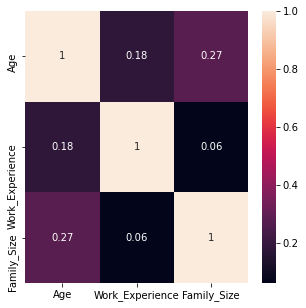

In [27]:
train_x = pd.DataFrame(train, columns = [col for col in train.columns if col != 'Segmentation'])
plt.figure(figsize=[5, 5])
sns.heatmap(abs(train_x.corr()),annot=True)
plt.show()

使用spearman系数检查离散型变量之间的相关性

In [28]:
for i in range(1, len(cat_vals)):
    feature = cat_vals[i]
    feature1 = cat_vals[i - 1]
    cor = train_x[feature].corr(train_x[feature1], method = 'spearman')
    if abs(cor) >= 0.6:
        print("WARMING!{} and {} has a large correlation".format(feature, feature1))
    print("correlationship between {} and {} is: {}".format(feature, feature1, abs(cor)))

correlationship between Ever_Married and Gender is: 0.10951029177169132
correlationship between Graduated and Ever_Married is: 0.1905196101220117
correlationship between Profession and Graduated is: 0.31674638111252
correlationship between Spending_Score and Profession is: 0.20322569923310252
correlationship between Var_1 and Spending_Score is: 0.03631077561567557


使用kendall系数检查离散型变量与数值型变量之间的相关性

In [29]:
for numval in num_vals:
    for catval in cat_vals:
        cor = train_x[numval].corr(train_x[catval], method = 'kendall')
        if abs(cor) >= 0.6:
            print("WARMING!{} and {} has a large correlation".format(numval, catval))
        print("correlationship between {} and {} is: {}".format(numval, catval, abs(cor)))

correlationship between Age and Gender is: 0.019875764525466896
correlationship between Age and Ever_Married is: 0.49517611724760313
correlationship between Age and Graduated is: 0.2442180694223303
correlationship between Age and Profession is: 0.09346321503493081
correlationship between Age and Spending_Score is: 0.2787578131600199
correlationship between Age and Var_1 is: 0.12635661626151934
correlationship between Work_Experience and Gender is: 0.03985142658367564
correlationship between Work_Experience and Ever_Married is: 0.062058288602013546
correlationship between Work_Experience and Graduated is: 0.035866484416742894
correlationship between Work_Experience and Profession is: 0.018513680054691332
correlationship between Work_Experience and Spending_Score is: 0.0277946655160932
correlationship between Work_Experience and Var_1 is: 0.0066544853631675125
correlationship between Family_Size and Gender is: 0.06744853277061523
correlationship between Family_Size and Ever_Married is: 0

变量之间均无明显相关性(即,不存在多重共线性),可以直接用于计算

需要注意的是, 如果使用分类算法中的树类模型(如随机森林, XGB等), 预测结果不受多重共线性影响.但模型解释性会受影响. 所以在特征较少的情况下, 还是需要人工剔除相关系数过高的两项的其中之一.

分类算法中的逻辑回归和线性回归受多重共线性影响较大(共线性会导致冗余, 减小模型泛化能力, 也就是说会导致过拟合), 当数据极多且拥有多重共线性, 难以分析剔除时, 如果必须使用回归算法, 那么应采用岭回归或使用PCA(主成分分析)去除多重共线性(模型可解释性也会降低, 但是当数据有成百上千个维度时,通常也不需要解释)

聚类算法也受多重共线性影响,与线性回归一样, 需要使用分析剔除/使用PCA降维的手段去除多重共线性

## 1.5 离散型变量转为可计算的数值

通过前面的可视化观察,除Spending_Score外其余变量之间似乎都没有明显的相关性

我们将Spending_Score做Order Encoding处理,其他使用Dummy Encoding处理

In [30]:
def replace_score(df):
    def mapping(x):
        if x == 'Low':
            return 0
        elif x == 'Average':
            return 1
        return 2
    df['Spending_Score'] = df['Spending_Score'].apply(lambda x: mapping(x))

In [31]:
replace_score(train_x)

In [32]:
def replace_cats(df):
    for feature in cat_vals:
        if feature != 'Spending_Score':
            dummy_features = pd.get_dummies(df[feature], drop_first=True)
            df = pd.concat([df, dummy_features], axis = 1)
            df.drop(feature, axis = 1, inplace = True)
    return df

In [33]:
train_x = replace_cats(train_x)

In [34]:
train_x.describe(include = 'all')

,Age,Work_Experience,Spending_Score,Family_Size,Male,Yes,Yes,Doctor,Engineer,Entertainment,...,Healthcare,Homemaker,Lawyer,Marketing,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
count,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,...,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000,10695.000000
mean,43.511828,2.453483,0.542590,2.850584,0.546143,0.594016,0.623843,0.086957,0.087424,0.116877,...,0.163628,0.030669,0.078915,0.037681,0.052641,0.101823,0.137915,0.010659,0.656194,0.025152
std,16.774158,3.249413,0.740146,1.504225,0.497890,0.491104,0.484443,0.281785,0.282469,0.321289,...,0.369955,0.172426,0.269619,0.190433,0.223327,0.302430,0.344827,0.102696,0.474999,0.156594
min,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,53.000000,3.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,89.000000,14.000000,2.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.6 Normalization

In [35]:
train_x = (train_x - train_x.min())/(train_x.max() - train_x.min())

# 2. 使用Kmeans建模

在数据中我们已经知道目标产品数量为4了,也就是说聚类的n_cluster已经明确,那么我们可以用kmeans实现

In [36]:
from sklearn.cluster import KMeans

In [37]:
estimator = KMeans(n_clusters=4)
estimator.fit(train_x)
label_pred = estimator.labels_
train_x['cluster_kmean'] = label_pred

In [38]:
train_x['cluster_kmean'].value_counts()

0    4353
3    2223
2    2149
1    1970
Name: cluster_kmean, dtype: int64

In [39]:
train['Segmentation'].value_counts()

D    3027
A    2818
C    2442
B    2408
Name: Segmentation, dtype: int64

# 3. 层次聚类

在不知道n_clusters数量时,可以采用层次聚类方法.但层次聚类同样可以定义该参数.

在知道n_clusters数量且解空间是以中心点为半径扩展时,推荐采用kmeans.层次聚类存在速度过慢的问题, 但可以聚类非凸或不知道目标聚类个数的数据

In [40]:
from sklearn.cluster import AgglomerativeClustering

In [41]:
estimator = AgglomerativeClustering(n_clusters = 4)
estimator.fit(train_x)
label_pred = estimator.labels_
train_x['cluster_hier'] = label_pred

In [42]:
train_x['cluster_hier'].value_counts()

0    4353
3    2223
1    2145
2    1974
Name: cluster_hier, dtype: int64

In [43]:
train['Segmentation'].value_counts()

D    3027
A    2818
C    2442
B    2408
Name: Segmentation, dtype: int64

In [58]:
res = train_x['cluster_hier'].value_counts().tolist()
real = train['Segmentation'].value_counts().tolist()

correct = 0
for i in range(len(res)):
    correct += min(real[i], res[i])
acc = correct/len(train)
print("准确率{}%".format(acc * 100))

准确率87.60168302945301%
